# Exploring Echoregions Regions2D Functionality

This notebook parses region values from an Echoview `.evr` file and creates a region mask for the corresponding Echogram data.

### Installation

Prior to running this notebook and all other notebooks, make sure to pip install Echoregions and Echopype Plotting Library.

Install Using PyPi:

`pip install echoregions`

`pip install echopype[plot]`

Install Using Latest Github Main Branch Commit:

`pip install git+https://github.com/OSOceanAcoustics/echoregions.git`

`pip install git+https://github.com/OSOceanAcoustics/echopype.git@plot`

In [25]:
# Importing Packages
import matplotlib.pyplot as plt
import urllib.request
import shutil
import xarray as xr
import numpy as np
from pandas.testing import assert_frame_equal
from echopype.visualize.cm import cmap_d

import echoregions as er

### Regions Data Reading

To start this tutorial, we first download `evr` data from Echoregion's Github Repository and parse the `.evr` file using Echoregion's `read_evr` function. 

The parsing is based off of the `.evr` data description shown on Echoview's website: [Region Attributes](https://support.echoview.com/WebHelp/Reference/File_Formats/Export_File_Formats/2D_Region_definition_file_format.htm).

In [26]:
# Set path to test data
TEST_DATA_PATH = 'https://raw.githubusercontent.com/OSOceanAcoustics/echoregions/update_notebook_docs_base_main/echoregions/test_data'

# Download example EVR File
urllib.request.urlretrieve(f"{TEST_DATA_PATH}/transect.evr","transect.evr")

# Read EVR file
regions2d = er.read_evr('transect.evr')

#### Regions2D as a DataFrame

`regions2d` is a specialized object but it has a `data` attribute which is a simple dataframe.

In [27]:
# Grab regions2d dataframe
regions2d_df = regions2d.data

In [28]:
regions2d_df.head(3)

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
0,transect.evr,EVRG,7,13.0.378.44817,1,13,4,0,6,-1,...,2019-07-02 08:10:09.425500,-9999.99,9999.99,Log,2,COM,"[2019-07-02T03:50:54.629500000, 2019-07-02T03:...","[-9999.99, 9999.99, 9999.99, -9999.99]","[Switched from recording to ""night"" folder to ...",[]
1,transect.evr,EVRG,7,13.0.378.44817,2,13,4,0,6,-1,...,2019-07-02 12:32:31.740500,-9999.99,9999.99,Log,2,Com,"[2019-07-02T12:32:30.175500000, 2019-07-02T12:...","[-9999.99, 9999.99, 9999.99, -9999.99]",[Recording 10 min of passive data],[]
2,transect.evr,EVRG,7,13.0.378.44817,3,13,4,0,6,-1,...,2019-07-02 12:43:10.758500,-9999.99,9999.99,Log,2,COM,"[2019-07-02T12:43:06.273000000, 2019-07-02T12:...","[-9999.99, 9999.99, 9999.99, -9999.99]",[End passive data collection and back to active],[]


The `regions2d` object can be subsetted using the `select_region` function and with parameters related to region class, time, and depth. For this example let us select a trawl region based on the `region_class` parameter:

In [29]:
trawl_regions = regions2d.select_region(region_class="Trawl")

In [30]:
trawl_regions

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
17,transect.evr,EVRG,7,13.0.378.44817,18,13,4,0,4,-1,...,2019-07-02 19:52:21.531,9.244758,758.973217,Trawl,0,AWT20,"[2019-07-02T18:40:51.809700000, 2019-07-02T18:...","[200.0, 300.0, 300.0, 200.0]",[],[]
18,transect.evr,EVRG,7,13.0.378.44817,19,13,4,0,4,-1,...,2019-07-02 19:52:21.531,9.244758,758.973217,Trawl,0,AWT20,"[2019-07-02T19:22:21.531000000, 2019-07-02T19:...","[220.0, 350.0, 350.0, 220.0]",[],[]


Now notice that these regions are not closed:

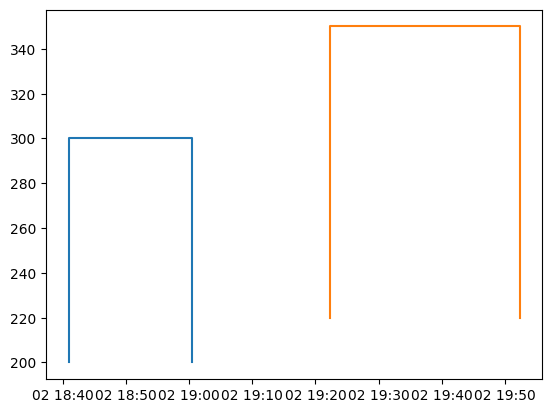

In [31]:
for _, point in trawl_regions.iterrows():
    plt.plot(point["time"], point["depth"])

We can close these regions and re-plot:

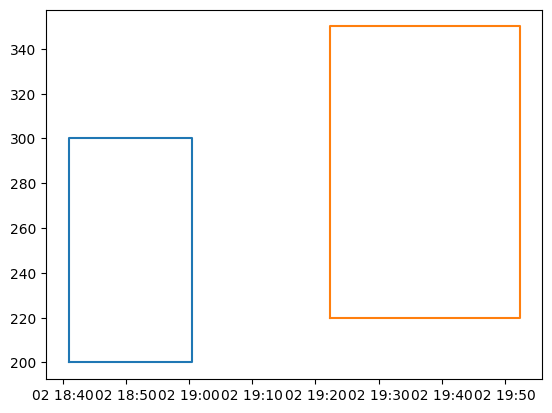

In [32]:
trawl_regions_closed = regions2d.close_region(region_class="Trawl")

for _, row in trawl_regions_closed.iterrows():
    plt.plot(row["time"], row["depth"])

To select Trawl regions, close regions, and plot regions, one can also just run the following using the object's `plot` function:

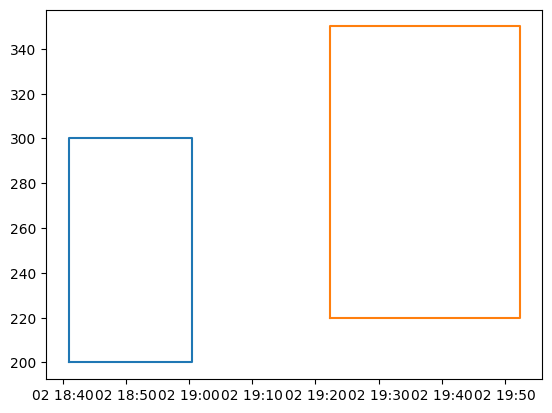

In [33]:
regions2d.plot(region_class="Trawl", close_regions=True)

### Echogram Data Reading and Plotting

Let's now download and plot an echogram created using [Echopype](https://echopype.readthedocs.io/en/stable/). Echopype is a comprehensive software designed for parsing sonar backscatter and conducting scientific computations. It offers a wide array of functionalities, including the creation of echograms, which are visual representations formed by the echoes received from sonar signals. Additionally, Echopype seamlessly integrates with Echoregions, a specialized software for parsing echogram annotations. For now, we will primarily be working with the `ds_Sv["Sv"]` backscatter volume data variable, which when plotted becomes an echogram, but there are many more data variables that can be used when working with Echopype.

In [34]:
# Download example Echopype Sv Zarr File
urllib.request.urlretrieve(f"{TEST_DATA_PATH}/transect.zip","transect.zip")

# Extract the ZIP file
shutil.unpack_archive("transect.zip", "")

# Read volume backscattering strength (Sv) data
ds_Sv = xr.open_dataset('transect.zarr', engine="zarr")

In [35]:
ds_Sv["Sv"]

<xarray.DataArray 'Sv' (depth: 3955, ping_time: 1681, channel: 3)>
[19945065 values with dtype=float64]
Coordinates:
  * channel       (channel) <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ... '...
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    range_sample  (depth) int64 ...
Attributes:
    actual_range:  [-156.0, 37.68]
    long_name:     Volume backscattering strength (Sv re 1 m-1)
    units:         dB

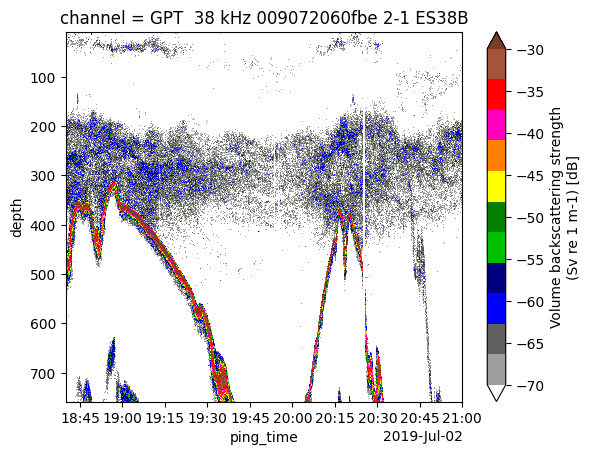

In [36]:
# Plot the 38 kHz backscatter channel
ds_Sv["Sv"].isel(channel=1).plot.pcolormesh(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap=cmap_d["ek500"])

### Plotting Echogram and Region

From the two previous plots, one can kind of see how they're related on both the depth and time dimensions. Now let's see a region annotation overlayed on top of the Echogram dataset.

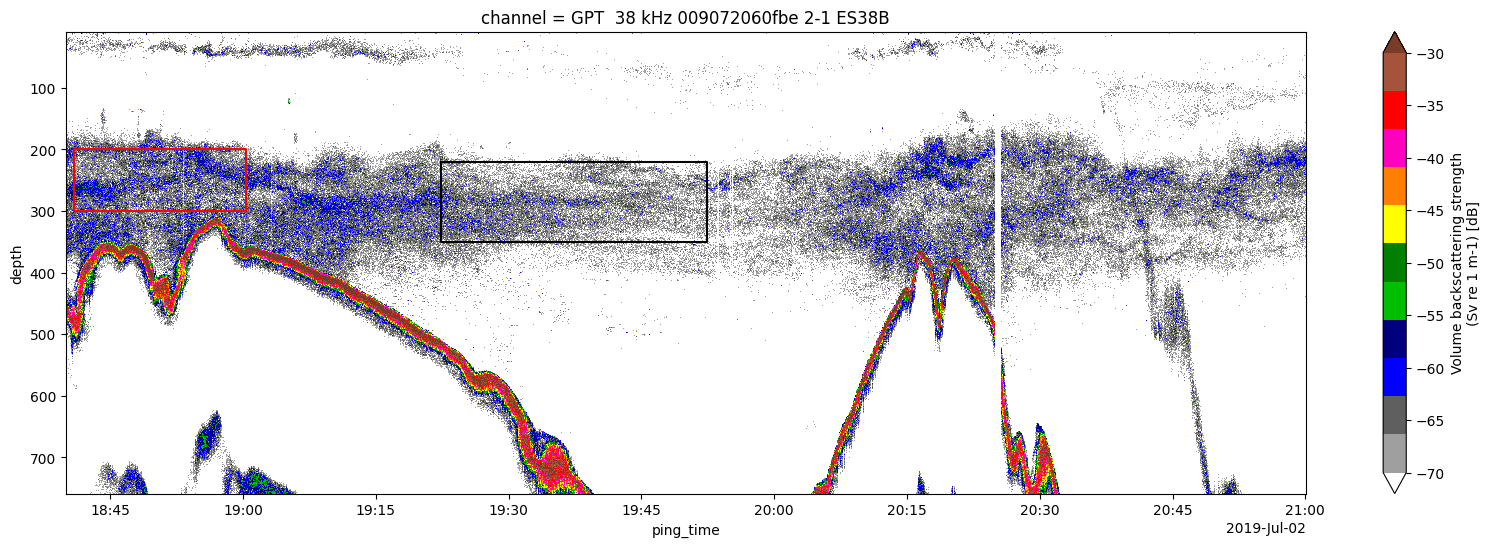

In [37]:
# Plotting the echogram data and the trawl region
plt.figure(figsize=(20, 6))
for _, point in trawl_regions_closed.iterrows():
    color = 'red' if point['region_id'] == 18 else 'black'  # Assign red for region ID 18 and black for region ID 19
    plt.plot(point["time"], point["depth"], fillstyle='full', markersize=1, color=color)

ds_Sv.Sv.isel(channel=1).T.plot(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap=cmap_d["ek500"])

### Masking Echogram and Region

From the previous plot, one can kind of see how they're related on both the depth and time dimensions. Now let's see a region annotation overlayed on top of the Echogram dataset.

For machine learning training purposes, and more specifically, for computer vision segmentation model training, a region polygon is not enough and so we require masks of the echogram data, which indicate which points are within the region.

The `Regions2D` class has a function to do this specific task: `mask`. This `mask` function is essentially a wrapper over the [`mask_3D`](https://regionmask.readthedocs.io/en/stable/notebooks/mask_3D.html) function from [regionmask](https://github.com/regionmask/regionmask). The 3D in `mask_3D` is important here since the masks we get out of `regions2d` will be 3D masks by default (when `collapse_to_2d = False` in `regions2d.mask`, which is the default value). This means that the mask will have three dimensions: `ping_time`, `depth`, and `region_id`, where `region_id` is the unique identifier of a region. The separation of regions via the `region_id` dimension allows the storage of 'within region' and 'outside region' information as 1 and 0 respectively.

If the user passes in `collapse_to_2d = True` they will produce a 2D mask where the mask will have dimensions `ping_time`, and `depth`, and the 'within region' values will be the `region_id` values and 'outside region' values will be NaN.

Let's look first at the default `collapse_to_2d = False` case:

In [38]:
# Use the built in mask function to create a mask
region_mask_ds, region_points = regions2d.mask(
    ds_Sv["Sv"].isel(channel=1).drop_vars("channel").compute(),
    region_class="Trawl",
    #collapse_to_2d= False, mask defaults to this so we can comment it out
)

Note that selecting 1 channel here is to ensure that our output is a single channel mask. The number of channels of the data array that is passed into the mask will match the number of channels of the output bottom mask data array.

The output should be the region mask itself and the points that constitute the region.

Note that even though we use `region_class` here to select the region to be masked, what is stored in the dataset as a dimension is the `region_id` since it is unique and `region_class` is not:

In [39]:
region_mask_ds

<xarray.Dataset>
Dimensions:      (region_id: 2, depth: 3955, ping_time: 1681)
Coordinates:
  * region_id    (region_id) int64 18 19
  * depth        (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
  * ping_time    (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-0...
Data variables:
    mask_labels  (region_id) int64 0 1
    mask_3d      (region_id, depth, ping_time) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

The values in the region mask should also just be 1s (within the region) and 0s (outside of the region):

In [40]:
print("Unique Values in Region Mask:", np.unique(region_mask_ds["mask_3d"].data))

Unique Values in Region Mask: [0 1]


As a sanity check, let us check that the `ping_time` and `depth` dimensions in the region mask `region_mask_ds` are equal to that in the backscatter data `ds_Sv["Sv"]`:

In [41]:
print(
    "Region Mask Ping Time Dimension Length:",
    len(region_mask_ds["ping_time"])
)
print(
    "Region Mask Depth Dimension Length:",
    len(region_mask_ds["depth"])
)
print(
    "Echogram Ping Time Dimension Length:",
    len(ds_Sv["Sv"]["ping_time"])
)
print(
    "Echogram Depth Dimension Length:",
    len(ds_Sv["Sv"]["depth"])
)

Region Mask Ping Time Dimension Length: 1681
Region Mask Depth Dimension Length: 3955
Echogram Ping Time Dimension Length: 1681
Echogram Depth Dimension Length: 3955


A plot of region id 18:

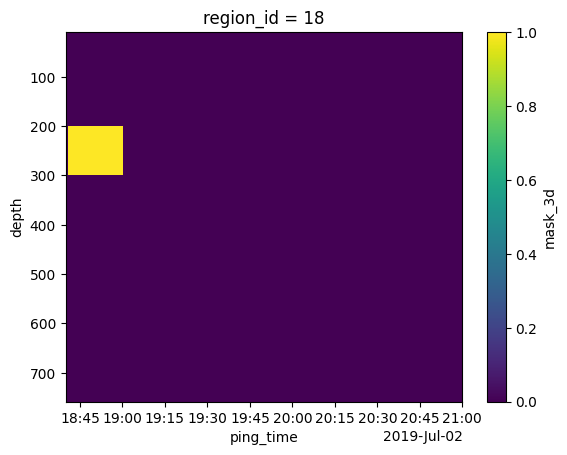

In [42]:
region_mask_ds["mask_3d"].sel(region_id=18).plot(y="depth", yincrease=False)

A plot of region id 19:

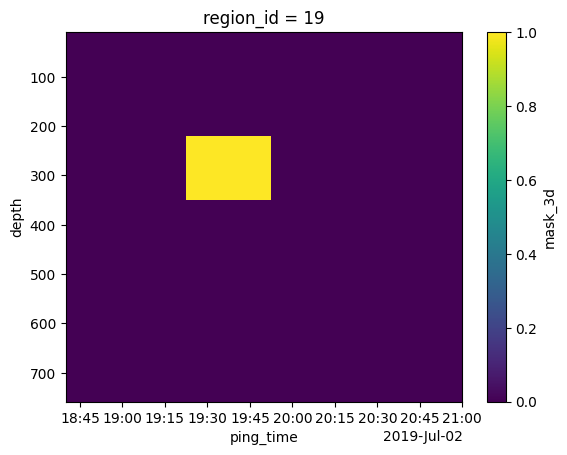

In [43]:
region_mask_ds["mask_3d"].sel(region_id=19).plot(y="depth", yincrease=False)

A plot of the 38 kHz channel where the mask is 1 and masked region's region id is 19:

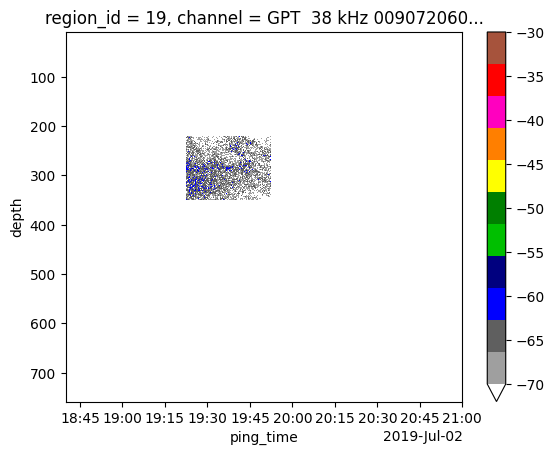

In [44]:
# Get only 38 kHz channel values where the mask is 1 and masked region's region id is 19
mask_exists_Sv = xr.where(
    region_mask_ds["mask_3d"].sel(region_id=19) == 1,
    ds_Sv["Sv"].isel(channel=1),
    np.nan,
)

# Plot the masked Sv
mask_exists_Sv.plot(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap=cmap_d["ek500"])

Now let us look at what is produced in the `collapse_to_2d = True` case:

In [45]:
# Set collapse_to_2d = True
region_mask_2d_ds, region_points_2d = regions2d.mask(
    ds_Sv["Sv"].isel(channel=1).drop_vars("channel").compute(),
    region_class="Trawl",
    collapse_to_2d=True,
)

In [46]:
region_mask_2d_ds["mask_2d"]

<xarray.DataArray 'mask_2d' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * depth      (depth) float64 9.15 9.34 9.529 9.719 ... 757.9 758.1 758.3 758.5
  * ping_time  (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-02T...

The values in the 2d region mask should be 18, 19, and NaN:

In [47]:
print("Unique Values in Region Mask:", np.unique(region_mask_2d_ds["mask_2d"].data))

Unique Values in Region Mask: [18. 19. nan]


Note that `ds_Sv` is the entire dataset containing many data variables that Echoregions does not work with, and so passing in the entire dataset to `regions2d.mask` will produce an error since it expects a single data array `ds_Sv["Sv"]`:

In [48]:
# Test ds_Sv
regions2d.mask(
    ds_Sv,
    region_class="Trawl",
)

TypeError: Input da_Sv must be of type DataArray. da_Sv was instead of type <class 'xarray.core.dataset.Dataset'>

### Saving to ".csv" and Reading From ".csv"

So now that we have our mask and our region polygon points, how do we save them?

We can use the Echoregions `read_regions_csv` function to first load it onto a region2d object and use the region2d object's `to_csv` function to save the regions2d dataframe as a `.csv`.

In [ ]:
# Create new regions2d object
from_mask_regions = er.read_regions_csv(region_points)

# Save to .csv
from_mask_regions.to_csv("from_mask_regions.csv", index=False)

Now if you need to load this `.csv` into a regions object we can again use `read_regions_csv` since it takes in both file locations (Path/str objects) and Pandas DataFrames:

In [ ]:
# Create another new regions2d object
from_csv_regions = er.read_regions_csv("from_mask_regions.csv")

As another sanity check, let's check if these dataframes are equal (with index reset):

In [ ]:
try:
    assert_frame_equal(from_mask_regions.data.reset_index(drop=True), from_csv_regions.data.reset_index(drop=True))
    print("The two DataFrames are equal.")
except AssertionError:
    print("The two DataFrames are not equal.")

The two DataFrames are equal.
